# Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import train dataframe

In [2]:
df_train = pd.read_json("../data/train/TRAIN.json", encoding='utf-8')
# Convert the name of the columns to uppercase
df_train.columns = map(str.upper, df_train.columns)
# Drop the null register if the PALABRAS_EMPLEO_TEXTO or CATEGORIA or SUBCATEGORIA is null
print("Before:" + str(df_train.shape))
df_train = df_train.dropna(subset=['PALABRAS_EMPLEO_TEXTO', 'CATEGORIA', 'SUBCATEGORIA'])
print("After:" + str(df_train.shape))
df_train['NUM_WORDS'] = df_train['PALABRAS_EMPLEO_TEXTO'].apply(lambda x: len(x.split(" ")) - 1)
df_train.head(2)

Before:(48893, 6)
After:(48893, 6)


,ID_OFERTA,SUBCATEGORIA,CATEGORIA,PALABRAS_EMPLEO_TEXTO,ID_PUESTO_ESCO,ID_PUESTO_ESCO_ULL,NUM_WORDS
0,ef5a8ae0a743018628df9bd53893bb,Administración,Administración de empresas,ADMINISTRATIVO INGLES NAVISION EMPRESAS CARACT...,1634,1634,13
1,47137c06a640348ca4cb7dcbf938b1,Medicina general,Sanidad y salud,MEDICO MEDICINA DIAGNOSTICO TRATAMIENTO LICENC...,611,611,10


# Group by occupations

In [3]:
# Group the dataframe by ID_PUESTO_ESCO_ULL and calculate the mean of the 'NUM_WORDS' column
df_train_grouped = df_train.groupby('ID_PUESTO_ESCO_ULL')['NUM_WORDS'].agg(['mean']).reset_index()
# Count the occurrences of each unique value in the 'ID_PUESTO_ESCO_ULL' column
counts = df_train['ID_PUESTO_ESCO_ULL'].value_counts()

# Create a DataFrame from the counts
df_counts = counts.reset_index()

# Rename the columns for clarity
df_counts.columns = ['ID_PUESTO_ESCO_ULL', 'Count']

# Sort the DataFrame by 'ID_PUESTO_ESCO_ULL' and reset the index
df_counts = df_counts.sort_values(by='ID_PUESTO_ESCO_ULL').reset_index(drop=True)

# Now join both dataframes
df_train_grouped = df_train_grouped.join(df_counts['Count'])
df_train_grouped.head(2)

,ID_PUESTO_ESCO_ULL,mean,Count
0,33,27.000000,5
1,39,41.355556,45


# Visualize the Mean of words Vs Num of offers

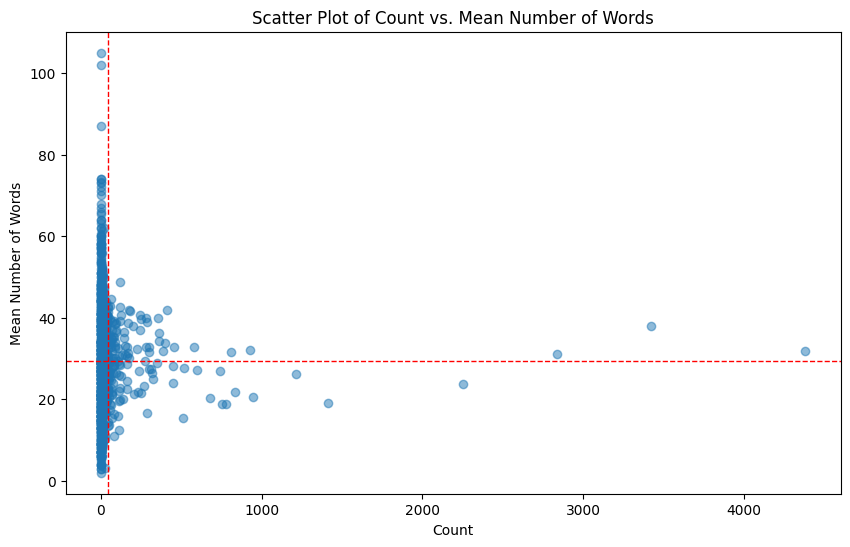

In [4]:
# Scatter plot
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.scatter(df_train_grouped['Count'], df_train_grouped['mean'], alpha=0.5)  # alpha controls the transparency of points

# Now represent a vertical line at the mean of the 'Count' column
plt.axvline(df_train_grouped['Count'].mean(), color='red', linestyle='dashed', linewidth=1)
# Now represent a horizontal line at the mean of the 'mean' column
plt.axhline(df_train_grouped['mean'].mean(), color='red', linestyle='dashed', linewidth=1)

# Set labels and title
plt.xlabel('Count')
plt.ylabel('Mean Number of Words')
plt.title('Scatter Plot of Count vs. Mean Number of Words')

# Show the plot
plt.show()

# Visualize the Mean of words Vs Num of offers

Loading BokehJS ...

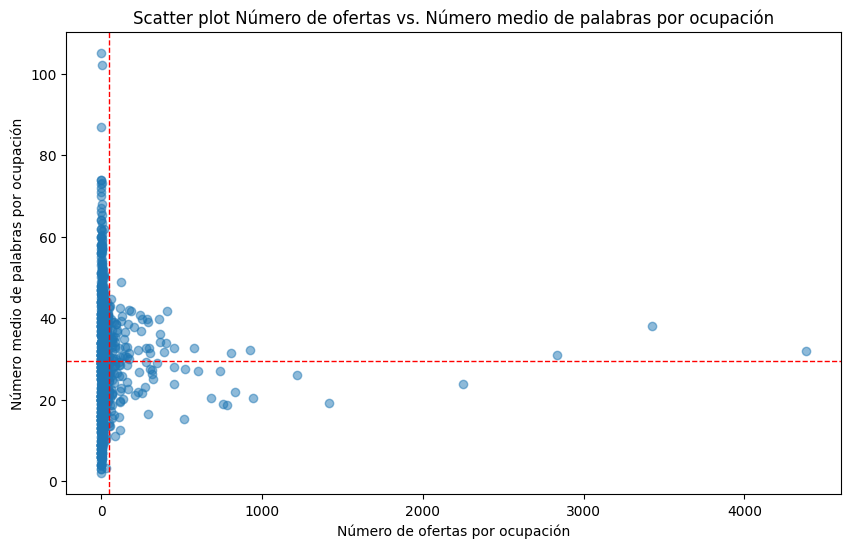

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from bokeh.plotting import figure, show, output_notebook, output_file
from bokeh.models import HoverTool, ColumnDataSource

min_offers = 0
max_offers = 10000
min_words = 0
max_words = 10000

# Filter the DataFrame to include only rows where 'Count' is inside the range of min_offers and max_offers
filtered_df = df_train_grouped[(df_train_grouped['Count'] >= min_offers) & (df_train_grouped['Count'] <= max_offers)]
# Filter the DataFrame to include only rows where 'mean' is inside the range of min_mean and max_mean
filtered_df = filtered_df[(filtered_df['mean'] >= min_words) & (filtered_df['mean'] <= max_words)]

x_label = 'Número de ofertas por ocupación'
y_label = 'Número medio de palabras por ocupación'
title = 'Scatter plot Número de ofertas vs. Número medio de palabras por ocupación'
# Matplotlib Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(filtered_df['Count'], filtered_df['mean'], alpha=0.5)
plt.axvline(filtered_df['Count'].mean(), color='red', linestyle='dashed', linewidth=1)
plt.axhline(filtered_df['mean'].mean(), color='red', linestyle='dashed', linewidth=1)
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title(title)

# Bokeh Scatter Plot with Hover
source = ColumnDataSource(filtered_df)

p = figure(width=800, height=500, title=title, x_axis_label=x_label, y_axis_label=y_label) 
p.circle(x='Count', y='mean', source=source, size=10, color='blue', alpha=0.5)

hover = HoverTool()
hover.tooltips = [("ID_PUESTO_ESCO_ULL", "@ID_PUESTO_ESCO_ULL"),
                  ("Count", "@Count"),
                  ("Mean", "@mean")]

p.add_tools(hover)

# Specify the output HTML file
output_file("../html/scatter_plot_interactive.html")

output_notebook()
show(p)


# Exporting training visualization dataframe

In [6]:
df_train_grouped.to_csv("../data/train/df_train_grouped_visualization_words_offers.csv", index=False, encoding='utf-8')
# Add a description to the file	
f = open("../data/train/df_train_grouped_visualization_words_offers.txt", "w")
f.write("Este dataframe contiene el número medio de palabras por ocupación y el número de ofertas por ocupación.")
f.close()
df_train_grouped['Count']

0        5
1       45
2       42
3        5
4       17
        ..
1011    57
1012     2
1013     1
1014    10
1015     2
Name: Count, Length: 1016, dtype: int64

# Get top 10 ocupaciones

Number of unique ID_PUESTO_ESCO_ULL:  1016


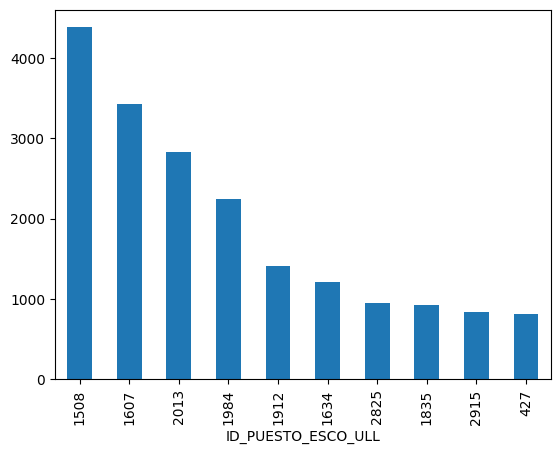

In [7]:
# Get the number of repetitions for each ID_PUESTO_ESCO_ULL
counts = df_train['ID_PUESTO_ESCO_ULL'].value_counts()
print("Number of unique ID_PUESTO_ESCO_ULL: ", len(counts))
# Plot the histogram of the top 10 with more repetitions sorted by the number of repetitions
counts[:10].plot(kind='bar')
plt.show()


In [8]:
# Delete randomly the register for number of ID_PUESTO_ESCO_ULL > 1000 to balance the dataset, but delete randomly
# the register for number of ID_PUESTO_ESCO_ULL < 1000 to balance the dataset
print("Before: ", df_train.shape[0])
# df_train = df_train[df_train['ID_PUESTO_ESCO_ULL'].isin(counts[counts < 1000].index)] This line deletes the ID_PUESTO_ESCO_ULL with less than 1000 repetitions
print("After: ", df_train.shape[0])

Before:  48893
After:  48893
